In [1]:
#Importing the libraries
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from matplotlib import pyplot
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.utils.np_utils import to_categorical
from wordcloud import WordCloud,STOPWORDS
import matplotlib.pyplot as plt
%matplotlib inline
import re
import numpy as np

In [2]:
#Importing the data
data = pd.read_csv('Sentiment.csv')

In [3]:
data.head() #printing first five rows

,id,candidate,candidate_confidence,relevant_yn,relevant_yn_confidence,sentiment,sentiment_confidence,subject_matter,subject_matter_confidence,candidate_gold,...,relevant_yn_gold,retweet_count,sentiment_gold,subject_matter_gold,text,tweet_coord,tweet_created,tweet_id,tweet_location,user_timezone
0,1,No candidate mentioned,1.0,yes,1.0,Neutral,0.6578,None of the above,1.0000,NaN,...,NaN,5,NaN,NaN,RT @NancyLeeGrahn: How did everyone feel about...,NaN,2015-08-07 09:54:46 -0700,629697200650592256,NaN,Quito
1,2,Scott Walker,1.0,yes,1.0,Positive,0.6333,None of the above,1.0000,NaN,...,NaN,26,NaN,NaN,RT @ScottWalker: Didn't catch the full #GOPdeb...,NaN,2015-08-07 09:54:46 -0700,629697199560069120,NaN,NaN
2,3,No candidate mentioned,1.0,yes,1.0,Neutral,0.6629,None of the above,0.6629,NaN,...,NaN,27,NaN,NaN,RT @TJMShow: No mention of Tamir Rice and the ...,NaN,2015-08-07 09:54:46 -0700,629697199312482304,NaN,NaN
3,4,No candidate mentioned,1.0,yes,1.0,Positive,1.0000,None of the above,0.7039,NaN,...,NaN,138,NaN,NaN,RT @RobGeorge: That Carly Fiorina is trending ...,NaN,2015-08-07 09:54:45 -0700,629697197118861312,Texas,Central Time (US & Canada)
4,5,Donald Trump,1.0,yes,1.0,Positive,0.7045,None of the above,1.0000,NaN,...,NaN,156,NaN,NaN,RT @DanScavino: #GOPDebate w/ @realDonaldTrump...,NaN,2015-08-07 09:54:45 -0700,629697196967903232,NaN,Arizona


In [4]:
# Keeping only the neccessary columns
data = data[['text','sentiment']]

In [5]:
data.sentiment.value_counts()

Negative    8493
Neutral     3142
Positive    2236
Name: sentiment, dtype: int64

#### Observations :
1. There are 8493 negative tweets.
2. There are 3142 neutral tweets.
3. There are 2236 positive tweets.

In [6]:
#removing the neutral data
data = data[data.sentiment != 'Neutral']

In [7]:
data.sentiment.value_counts()

Negative    8493
Positive    2236
Name: sentiment, dtype: int64

Positive words


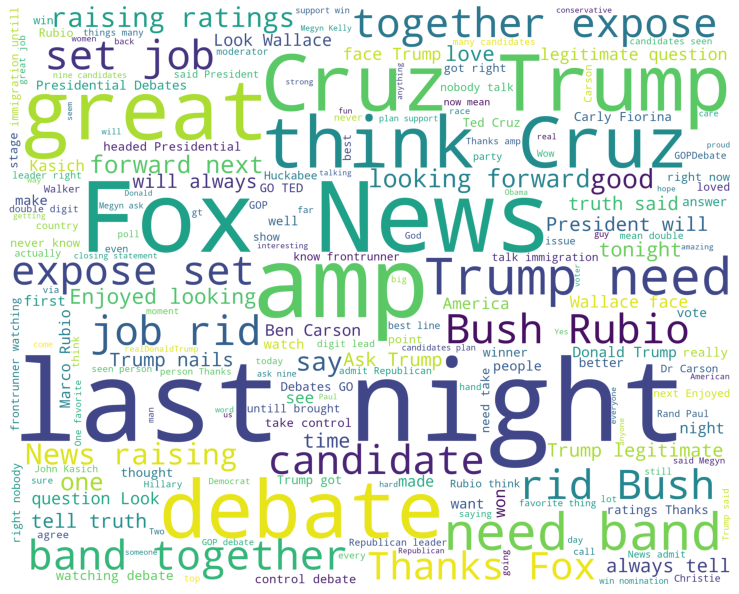

Negative words


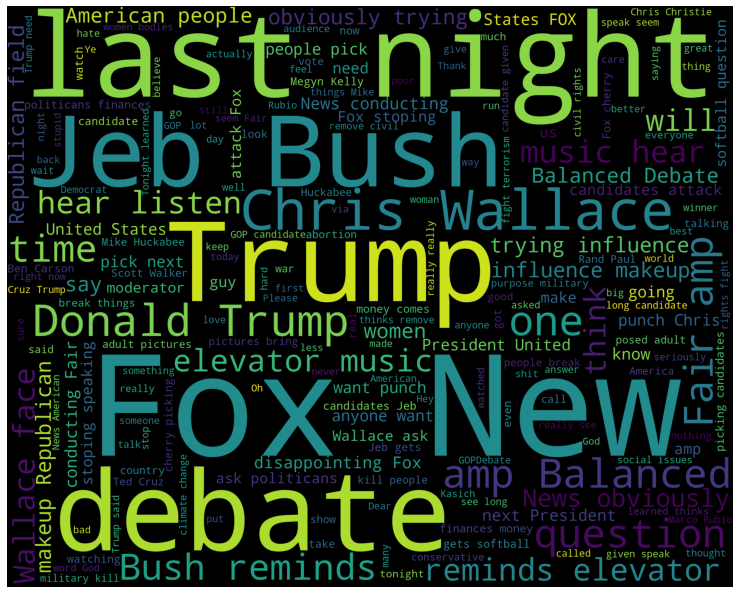

In [8]:
train_pos = data[data['sentiment'] == 'Positive'] #train_pos contains only positive data
train_pos = train_pos['text'] 
train_neg = data[data['sentiment'] == 'Negative'] #train_neg conatins only negative data
train_neg = train_neg['text']

#creating a wordcloud_plot function for printing the key words in both positive and negative sentiment
def wordcloud_plot(data, color = 'black'):
    words = ' '.join(data)
    cleaned_word = " ".join([word for word in words.split() #splitting the text into words
                            if 'http' not in word
                                and not word.startswith('@') #getting the words not starting with @
                                and not word.startswith('#') #getting the words not starting with #
                                and word != 'RT'
                            ])
    wordcloud = WordCloud(stopwords=STOPWORDS,background_color=color,width=2500,height=2000).generate(cleaned_word)
    plt.figure(1,figsize=(13, 13))
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.show()

    
print("Positive words")
wordcloud_plot(train_pos,'white')  #Printing the wordcloud plot for positive words
print("Negative words")
wordcloud_plot(train_neg) #pritnting the wordcloud plot for negative words

In [9]:
data['text'] = data['text'].apply(lambda x: x.lower()) #Lowering all the characters
data['text'] = data['text'].apply((lambda x: re.sub('[^a-zA-z0-9\s]', '', x))) #removing special characters

In [10]:
for idx, row in data.iterrows(): #Itertaing over all the rows for removing retweet 
    row[0] = row[0].replace('rt', ' ')

In [11]:
#Tokenization
max_fatures = 2000
tokenizer = Tokenizer(num_words=max_fatures, split=' ') #splitting the text into words
tokenizer.fit_on_texts(data['text'].values) #fitting the texts
X = tokenizer.texts_to_sequences(data['text'].values) #converting texts to sequences

In [12]:
X = pad_sequences(X) #Padding 

In [13]:
embed_dim = 128
lstm_out = 196
def createmodel():
    model = Sequential() #building the model
    model.add(Embedding(max_fatures, embed_dim,input_length = X.shape[1])) #pass input shape
    model.add(SpatialDropout1D(0.4))
    model.add(LSTM(lstm_out, dropout=0.2, recurrent_dropout=0.2)) #adding hidden layer with LSTM
    model.add(Dense(2,activation='softmax')) #output layer
    model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy']) #compiling
    return model

In [19]:
#LabelEncoder
labelencoder = LabelEncoder()
integer_encoded = labelencoder.fit_transform(data['sentiment']) #fitting the model
y = to_categorical(integer_encoded)
X_train, X_test, Y_train, Y_test = train_test_split(X,y, test_size = 0.33, random_state = 42) #splitting the data into train and test

In [20]:
batch_size = 32
model = createmodel()
model.fit(X_train, Y_train, epochs = 1, batch_size=batch_size, verbose = 2) #fitting the model
score,acc = model.evaluate(X_test,Y_test,verbose=2,batch_size=batch_size) #finding accuracy and loss of the model
print('score of the model is    : ' ,score)
print('Accuracy of the model is : ' ,acc)
print(model.metrics_names)

225/225 - 15s - loss: 0.4333 - accuracy: 0.8168
111/111 - 1s - loss: 0.3574 - accuracy: 0.8433
score of the model is    :  0.35737344622612
Accuracy of the model is :  0.843264639377594
['loss', 'accuracy']


#### Observations:
1. Score of the model is    : 35%
2. Accuracy of the model is : 84%

In [21]:
model.save('twitter_model.h5') #saving the model

In [22]:
#Validating the data
validation_size = 1500
X_validate = X_test[-validation_size:]
Y_validate = Y_test[-validation_size:] 

In [23]:
positive_content, negative_content, positive_tweet, negative_tweet = 0, 0, 0, 0 #taking all the TP,TF,FP,FN values
for x in range(len(X_validate)): #creating a function for validating the tweet prediction accuracy
    
    result = model.predict(X_validate[x].reshape(1,X_test.shape[1]),batch_size=1,verbose = 2)[0] #predicting the tweet
    
    if np.argmax(result) == np.argmax(Y_validate[x]): #comparing to their original
        if np.argmax(Y_validate[x]) == 0: 
            negative_tweet += 1 
        else:
            positive_tweet += 1
       
    if np.argmax(Y_validate[x]) == 0:
        negative_content += 1
    else:
        positive_content += 1


print("Positive tweet accuracy : ", positive_tweet/positive_content*100, "%")
print("Negative tweet accuracy : ", negative_tweet/negative_content*100, "%")

1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1

1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1